In [1]:
from importlib import reload
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

from binance.client import Client
from binance import enums

In [2]:
# Your API key and secret
API_KEY = ""
API_SECRET = ""

In [3]:
client = Client(API_KEY, API_SECRET)

In [9]:
# List of pairs you want to track
pairs = [
    ('BTC', 'USDT'),
    ('ETH', 'USDT'),
    ('XRP', 'USDT'),
    ('LTC', 'USDT'),
    ('BNB', 'USDT')
]
# https://python-binance.readthedocs.io/en/latest/genindex.html
# Kline/candlestick interval
interval = enums.KLINE_INTERVAL_1HOUR
# Time window for heatmap
display_window = pd.Timedelta(days=3)

In [13]:
from cryptoz.binance import BinanceHelper
from cryptoz import binance, utils, plot, stats

In [6]:
binance = BinanceHelper(client)

## Data

In [10]:
ohlcvs = binance.get_multiple_pair_ohlcv(pairs, interval)

In [11]:
ohlcvs.keys()

dict_keys([('BTC', 'USDT'), ('ETH', 'USDT'), ('XRP', 'USDT'), ('LTC', 'USDT'), ('BNB', 'USDT')])

## Basic statistics

### Price development

/Users/olegpolakow/Documents/SourceTree/cryptoz/cryptoz/utils.py:79: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  return df.expanding(**kwargs).apply(func)


   count      mean       std  min       25%       50%       75%       max
0  360.0  0.155297  0.109034  0.0  0.069991  0.117061  0.232556  0.422762


/Users/olegpolakow/Documents/SourceTree/cryptoz/cryptoz/plot.py:204: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/Users/olegpolakow/Documents/SourceTree/cryptoz/cryptoz/plot.py:205: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False
/Users/olegpolakow/Documents/SourceTree/cryptoz/cryptoz/plot.py:207: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/Users/olegpolakow/Documents/SourceTree/cryptoz/cryptoz/plot.py:208: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False


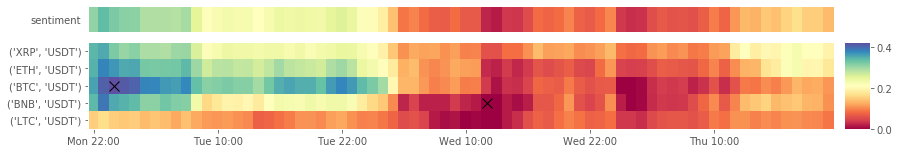

In [15]:
# Select column from each OHLCV
df = utils.to_df(ohlcvs, 'M')

# We want to somehow compare prices of all assets
# Thus let's normalize the prices based on their performance in the past
# 1 would mean that this time step is the new all time high (ATH)
# 0 would mean that this time step is the all time average
df = utils.expanding_normalize(df, 'minmax')

# Cut it to the window we are interested in
df = utils.cut_df(df, display_window)

# Plot price evolution (i.e. price development heatmap)
plot.evolution(df, plt.cm.Spectral, rank='last')

In [ ]:
df = utils.to_df(ohlc, 'C')
df = df.pct_change().dropna()
df.iloc[-1].sort_values()

In [ ]:
df = utils.cut_df(df, display_window)

plot.evolution(df, plt.cm.Spectral, plot.midpoint_norm(0), rank='last')

df.plot(figsize=(14, 8), cmap=plt.cm.tab20)
plt.show()

## volatility

In [ ]:
df = utils.to_df(ohlc, 'C')
df = df.std() / df.mean()
df.sort_values()

In [ ]:
window = 20

df = utils.to_df(ohlc, 'C')
df = df.rolling(window).std()
df = df.pct_change().dropna()
df = utils.cut_df(df, display_window)

plot.evolution(df, plt.cm.Spectral, plot.midpoint_norm(0), rank='last')

df.plot(figsize=(14, 8), cmap=plt.cm.tab20)
plt.show()

## volume

In [ ]:
window = 20

df = utils.to_df(ohlc, 'V')
# volume relative to mean of previous volumes
df = utils.rolling_normalize(df, 'mean', window)
df = utils.cut_df(df, display_window)

plot.evolution(df, plt.cm.Spectral, plot.midpoint_norm(0), rank='last')

# drawdown

## global

In [ ]:
stats.dd.now(ohlc)

## local

In [ ]:
recent_ohlc = utils.cut(ohlc, display_window)
df = stats.dd.from_ohlc(recent_ohlc)

plot.evolution(df, plt.cm.gist_earth_r, rank='last')

df.plot(figsize=(14, 8), cmap=plt.cm.tab20)
plt.show()

# correlation

In [ ]:
window = 20
base_pair = 'BTC/USDT'

df = utils.to_df(ohlc, 'C').pct_change().dropna()
df = stats.corr.rolling(df, window=window)
regex = re.compile(r'(%s-.+)' % base_pair)
df = df[list(filter(regex.search, df.columns))]
df.columns = list(map(lambda x: re.sub(r'(/%s)' % base_pair.split('/')[1], '', x), df.columns))
df.dropna(inplace=True)
df = utils.cut_df(df, display_window)

plot.evolution(df, plt.cm.gist_earth, rank='last')

df.plot(figsize=(14, 8), cmap=plt.cm.tab20)
plt.show()

# anomaly detection

## price

In [ ]:
window = 20
levels = [1, 2, 3, 4, 5]

df = utils.to_df(ohlc, 'C')
df = utils.rolling_normalize(df, 'std', window)
df.dropna(inplace=True)
df = utils.classify(df, levels, bipolar=True)
df = utils.cut_df(df, display_window)

plot.evolution(df, plt.cm.Spectral, plot.midpoint_norm(0), rank='last')

## volume

In [ ]:
window = 20
levels = [1, 2, 3, 4, 5]

df = utils.to_df(ohlc, 'V')
df = utils.rolling_normalize(df, 'std', window)
df.dropna(inplace=True)
df = utils.classify(df, levels, bipolar=True)
df = utils.cut_df(df, display_window)

plot.evolution(df, plt.cm.Spectral, plot.midpoint_norm(0), rank='last')

# oscillators

## *RSI*

In [ ]:
def RSI(df, window):
    delta = df.diff().dropna()
    up, down = delta * 0, delta * 0
    pos_mask = delta > 0
    neg_mask = delta < 0
    up[pos_mask] = delta[pos_mask]
    down[neg_mask] = -delta[neg_mask]
    up.iloc[window - 1] = up.iloc[:window].mean()
    up = up.iloc[window - 1:]
    down.iloc[window - 1] = down.iloc[:window].mean()
    down = down.iloc[window - 1:]
    rs = up.ewm(com=window - 1, adjust=False).mean() / down.ewm(com=window - 1, adjust=False).mean()
    rsi = 100 - 100 / (1 + rs)
    return rsi.reindex(df.index)

In [ ]:
window = 20
oversold = 30
overbought = 70

df = utils.to_df(ohlc, 'C')
df = RSI(df, window)
df = utils.trunk(df, [oversold, overbought])
df = utils.rescale(df, [-1, 1])
df = utils.cut_df(df, display_window)

plot.evolution(df, plt.cm.Spectral, plot.midpoint_norm(0), rank='last')

## *CCI*

In [ ]:
def cci(df, period):
    # (Typical Price  -  20-period SMA of TP) / (.015 x Mean Deviation)
    tp_sma = df.rolling(period).mean()
    md = df.rolling(period).apply(lambda a: np.fabs(a - a.mean()).mean())
    return (df - tp_sma) / (.015 * md)

In [ ]:
window = 20
oversold = -300
overbought = 300

df = utils.to_df(ohlc, 'C')
df = cci(df, window)
df = utils.trunk(df, [oversold, overbought])
df = utils.rescale(df, [-1, 1])
df = utils.cut_df(df, display_window)

plot.evolution(df, plt.cm.Spectral, plot.midpoint_norm(0), rank='last')

# signals

## *EMA crossover*

In [ ]:
def ema_crossover(df, ema_fast, ema_slow):
    fast = df.ewm(span=ema_fast, adjust=False).mean()
    slow = df.ewm(span=ema_slow, adjust=False).mean()
    df = fast - slow
    df[df > 0] = 1
    df[df < 0] = -1
    df = df.fillna(0)
    df = df.diff().dropna()
    pos_mask = df == 2
    neg_mask = df == -2
    df[pos_mask] = 1
    df[neg_mask] = -1
    df[~neg_mask & ~pos_mask] = 0
    return df

In [ ]:
fast_window = 7
slow_window = 25

df = utils.to_df(ohlc, 'M')
df = ema_crossover(df, fast_window, slow_window)
df = utils.cut_df(df, display_window)

plot.evolution(df, plt.cm.Spectral, plot.midpoint_norm(0), rank='last')

## *BollingerBand*

### How wide is the BB?

In [ ]:
def BB(df, window, k):
    sma = df.rolling(window=window).mean()
    std = df.rolling(window=window).std()
    BOLU = sma + std * k
    BOLD = sma - std * k
    return BOLD, BOLU

def corridor(BOLD, BOLU):
    return BOLU - BOLD

In [ ]:
window = 20
k = 2

df = utils.to_df(ohlc, 'C')
df = corridor(*BB(df, window, k)).dropna()
df = utils.rolling_normalize(df, 'mean', window).dropna()
df1 = utils.cut_df(df, display_window)

plot.evolution(df1, plt.cm.Spectral_r, plot.midpoint_norm(0), rank='last')

### Does the price exceed the BB?

In [ ]:
reload(utils)
df = utils.to_df(ohlc, 'C')
df = utils.range_rescale(df, BB(df, window, k), [-1, 1]).dropna()
df2 = utils.cut_df(df, display_window)

plot.evolution(df2, plt.cm.Spectral, plot.midpoint_norm(0), rank='last')